In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import DataLoader, random_split 
from torchvision.transforms import Normalize, Lambda
import torchvision

import sys, os
sys.path.append(os.path.join(os.path.dirname("./"), '..'))

from utils.Training import Train_MAE
from utils.CustomDataset import CustomDatasetSelfSupervised
from Models.MaskedAutoEncoders import MaskedAutoEncoder
from utils.Augmentation import augment_images

/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/mandakausthubh/anaconda3/envs/ViT/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this

In [2]:
# Loading the data

# Transform = Normalize(mean=[0.5], std=[0.5])
class MinMaxNormalize(object):
    """Normalizes a tensor to [0, 1] range using min and max of the tensor."""
    def __init__(self, min_val=None, max_val=None):
        """
        Args:
            min_val (float, optional): Fixed min value. If None, computed from input.
            max_val (float, optional): Fixed max value. If None, computed from input.
        """
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, tensor):
        """
        Args:
            tensor (torch.Tensor): Input tensor of shape (C, H, W) or (H, W)
        Returns:
            torch.Tensor: Normalized tensor in [0, 1]
        """
        if self.min_val is None or self.max_val is None:
            min_val = tensor.min()
            max_val = tensor.max()
        else:
            min_val = self.min_val
            max_val = self.max_val

        # Avoid division by zero
        if max_val == min_val:
            return torch.zeros_like(tensor) if min_val == 0 else torch.ones_like(tensor)
        
        return (tensor - min_val) / (max_val - min_val)


In [3]:
import matplotlib.pyplot as plt
import torch

def visualize_reconstruction(model, data, index=0, mask_ratio=0.75, patch_size=8, device='cpu'):
    """
    Visualize the original image, mask, and reconstructed image from the MAE model.
    
    Args:
        model: Trained MaskedAutoEncoder instance
        data: Dataset or list of images (tensors of shape (C, H, W))
        index: Index of the image to visualize (default: 0)
        mask_ratio: Fraction of patches to mask (default: 0.75)
        patch_size: Size of each patch (default: 16). Can be an integer (square patches) or tuple (rectangular patches).
        device: Device to run the model on (default: 'cpu')
    """
    model.eval()
    with torch.no_grad():
        image = data[index].unsqueeze(0).to(device)  # (1, C, H, W)
        loss, pred, mask = model(image, mask_ratio)
        recon = model.unpatchify(pred)  # (1, C, H, W)
        
        # Get image size
        _, C, H, W = image.shape
        
        # Handle patch_size as integer or tuple
        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)
        else:
            assert len(patch_size) == 2, "patch_size must be an integer or a tuple of two integers"
        
        # Calculate number of patches
        num_patches_h = H // patch_size[0]
        num_patches_w = W // patch_size[1]
        
        # Reshape mask for visualization
        mask_vis = mask.reshape(1, num_patches_h, num_patches_w).squeeze().cpu()
        
        # Plot original, mask, and reconstruction
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        if C == 1:
            axes[0].imshow(image.squeeze().cpu())
        else:
            axes[0].imshow(image.squeeze().cpu().permute(1, 2, 0))
        axes[0].set_title('Original')
        
        # Mask
        axes[1].imshow(mask_vis)
        axes[1].set_title('Mask')
        
        # Reconstructed image
        if C == 1:
            axes[2].imshow(recon.squeeze().cpu())
        else:
            axes[2].imshow(recon.squeeze().cpu().permute(1, 2, 0))
        axes[2].set_title('Reconstructed')
        
        plt.show()

In [4]:
from torch.optim.lr_scheduler import LambdaLR

def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """
    Creates a learning rate scheduler with:
    - Warmup (linear increase from 0 to initial LR) over `num_warmup_steps`.
    - Linear decay to 0 over remaining `num_training_steps - num_warmup_steps`.
    """
    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            # Warmup phase: increase LR from 0 to 1.0
            return float(current_step) / float(max(1, num_warmup_steps))
        # Decay phase: decrease LR from 1.0 to 0.0
        return max(
            0.0, 
            float(num_training_steps - current_step) / 
            float(max(1, num_training_steps - num_warmup_steps)))
    
    return LambdaLR(optimizer, lr_lambda, last_epoch)

In [16]:
Data_paths = [os.path.join(root, file) for root, _, files in os.walk( "../dataset/DatasetTask6A/no_sub") for file in files]
# Data_paths = Data_paths[:1000]

transform = torchvision.transforms.Compose([
    MinMaxNormalize(),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
])

dataset = CustomDatasetSelfSupervised(
            data = Data_paths,
            root = "",
            transform = MinMaxNormalize()
)

len(dataset), dataset[0].shape

(29449, torch.Size([1, 64, 64]))

In [6]:
train_len = int(len(dataset)*0.9)
test_len = len(dataset) - train_len


train, test = random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))
TrainLoader = DataLoader(train, batch_size=64, shuffle=True)
ValidationLoader = DataLoader(test, batch_size=64, shuffle=False)

In [ ]:
# Define the model
model = MaskedAutoEncoder(
        patch_size=8,
        encoder_embedding_dim=2048, encoder_num_heads=64, encoder_depth=8,
        decoder_embedding_dim=1024, decoder_num_heads=32, decoder_depth=4
    ).to(device='mps')

model = torch.complile(model)

In [8]:


# optimizer = torch.optim.AdamW(model.parameters(), lr=1.5e-8, weight_decay=0.05)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

model.norm_pix_loss = False
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05, betas=(0.9, 0.95))
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

total_epochs =150 
batches_per_epoch = len(TrainLoader)
total_training_steps = total_epochs * batches_per_epoch
num_warmup_steps = int(total_training_steps * 0.4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, total_training_steps)

Train_MAE(model, TrainLoader, ValidationLoader, optimizer,
            epochs=total_epochs, device='mps', scheduler=scheduler, masking_ratio=0.6)

Validation: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s, epoch=150, loss=0.00529]

Finished Training


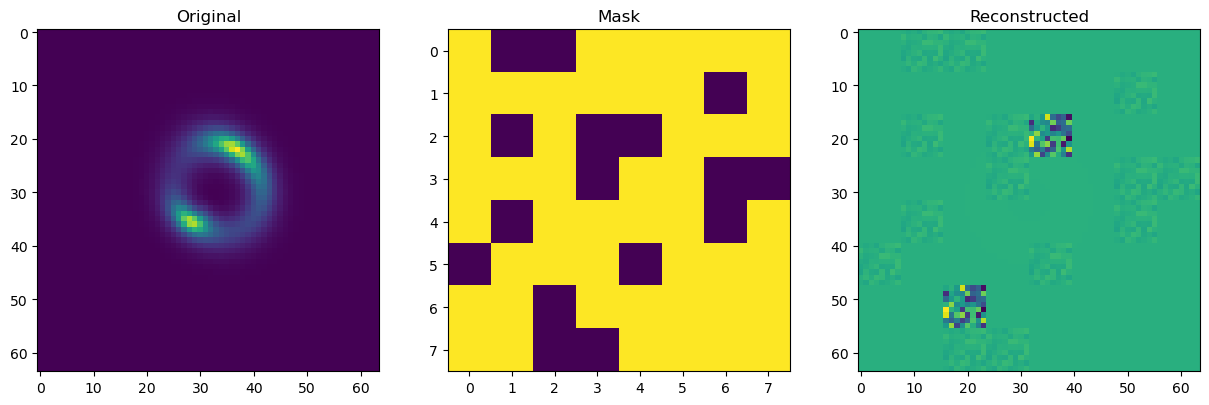

In [15]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
visualize_reconstruction(model, dataset, index=0, mask_ratio=0.75, patch_size=8, device=device)

In [10]:
torch.save(model.state_dict(), '../ModelWeights/MaskedAutoEncoder__Very_VeryDeep_Final__Solution.pth')

In [11]:
dataset[4].shape

torch.Size([1, 64, 64])

In [12]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
model.to(device)
image = torch.tensor(dataset[4]).unsqueeze(0).to(device)  # (1, 1, 64, 64)
latent, _, _ = model.forward_encoder(image, masking_ratio=0.75)
print(latent.shape)  # Should be (1, 4, 768) - 4 unmasked patches
print(latent.var(dim=1).mean())  # Variance across patches

torch.Size([1, 16, 2048])
tensor(6251359., device='mps:0', grad_fn=<MeanBackward0>)


/var/folders/mh/r3bzvtd11h105hlbbgl239940000gn/T/ipykernel_31976/3955301254.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(dataset[4]).unsqueeze(0).to(device)  # (1, 1, 64, 64)


In [13]:
print("Decoder Positional Embeddings Variance:", model.decoder_pos_embed.var(dim=1).mean().item())

Decoder Positional Embeddings Variance: 0.2576824724674225


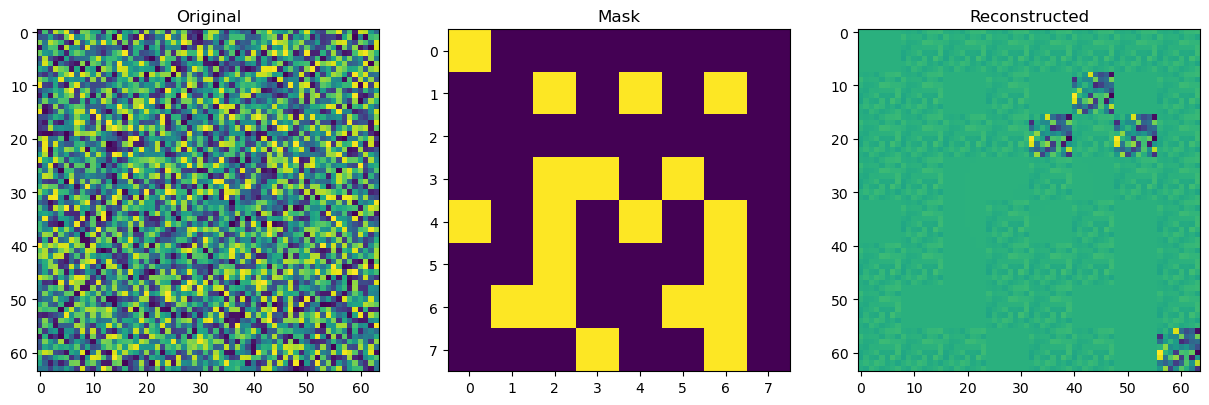

In [14]:
TestingData = torch.rand(4, 1, 64, 64).to(device)
visualize_reconstruction(model, TestingData, index=2, mask_ratio=0.3, patch_size=8, device=device)